In [1]:
%matplotlib inline
%gui qt

import os

import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage.exposure import rescale_intensity

import utoolbox.utils.files as fileutils
from utoolbox.container import Volume
from utoolbox.analysis.roi import extract_mask, mask_to_contour

plt.rcParams['figure.figsize'] = (8, 8)

In [2]:
source_folder = os.path.join("data", "20170906_RFiSHG6SCAAX")
print(source_folder)
file_list = fileutils.list_files(
    source_folder, 
    name_filters=[fileutils.ExtensionFilter('tif')]
)

#DEBUG bypass
file_path = file_list[1]
print(file_path)

data/20170906_RFiSHG6SCAAX
data/20170906_RFiSHG6SCAAX/stack0009.tif


In [3]:
raw = Volume(file_path)
print("shape={}".format(raw.shape))
print("dtype={}".format(raw.dtype))

shape=(145, 1024, 896)
dtype=float32


In [9]:
xy_proj = np.amax(rmask = extract_mask(data, iterative=False)aw, axis=0)
xy_proj = rescale_intensity(xy_proj, out_range=(0., 1.))

In [36]:
mask = extract_mask(xy_proj, iterative=False)
contour = mask_to_contour(mask)

#### Preview

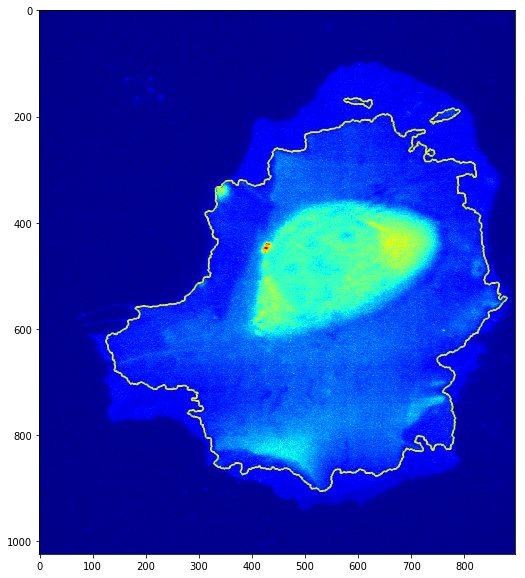

In [51]:
from skimage.segmentation import mark_boundaries
plt.figure(figsize=(10,10))
plt.imshow(xy_proj, cmap='jet')
plt.contour(contour, origin='lower', linewidths=1)